In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn.feature_selection import f_classif, f_regression, SelectKBest, chi2
from sklearn.ensemble          import IsolationForest

from sklearn.model_selection   import train_test_split
from sklearn.grid_search       import GridSearchCV
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_squared_error, mean_absolute_error, median_absolute_error

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import _pickle           as cPickle

import itertools
import argparse

from commonModel import loadData, FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS, TARGET_COLUMN

modelFileName = "model.pkl"
dataFileName  = "input/NizhnyNovgorod.csv"

Model = None
with open( modelFileName, 'rb') as fid:
        Model = cPickle.load(fid)
allDataFrame = loadData( dataFileName, COLUMN_TYPE='ALL' )

allDataFrame.head(10)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Tokenization took: 34.15 ms
Type conversion took: 48.94 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 13.37 ms
Type conversion took: 39.18 ms
Parser memory cleanup took: 0.01 ms
Shape of the data with all features: (109400, 11)
Shape of the data with numerical features: (109400, 11)
List of features contained our dataset: ['type', 'price', 'longitude', 'latitude', 'total_square', 'living_square', 'kitchen_square', 'number_of_rooms', 'floor_number', 'number_of_floors', 'building_type']
Shape of the data with numerical features: (63533, 11)
RobustScaler  [59007.04176027] [27882.38455357]
Shape of the data with numerical features: (46559, 11)


,type,price,longitude,latitude,total_square,living_square,kitchen_square,number_of_rooms,floor_number,number_of_floors,building_type
0,Вторичка,2850000.0,44.075417,56.283864,43.0,14.0,11.0,1,9,17,
1,Вторичка,8200000.0,43.942485,56.301539,98.5,52.0,14.0,3,3,17,
2,Вторичка,2600000.0,43.923782,56.310448,64.0,42.0,6.0,4,2,5,
3,Вторичка,2750000.0,44.064952,56.291499,50.0,30.0,9.0,2,3,5,
4,Вторичка,2650000.0,43.957127,56.329128,45.0,31.0,6.0,2,2,5,Кирпичный
5,Вторичка,2400000.0,44.023674,56.316345,76.0,44.0,12.0,2,6,9,
6,Вторичка,3700000.0,43.996545,56.317807,45.0,37.0,6.5,2,2,8,Кирпичный
7,Вторичка,3550000.0,44.079100,56.303541,41.8,18.6,11.3,1,9,9,Кирпичный
9,Вторичка,1900000.0,44.001350,56.310740,57.0,27.0,12.0,1,6,12,
12,Вторичка,4760000.0,43.943589,56.295000,105.0,64.0,10.0,4,8,9,Кирпичный


In [2]:
from commonModel import FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS

import warnings
warnings.filterwarnings('ignore')

NUMERICAL_COLUMNS = FLOAT_COLUMNS + INT_COLUMNS
testDataFrame = allDataFrame[NUMERICAL_COLUMNS]

FEATURES = list( testDataFrame.columns ); FEATURES.remove( TARGET_COLUMN )
COLUMNS  = list( testDataFrame.columns ); LABEL = TARGET_COLUMN;

index       = testDataFrame.index;
Y_dataFrame = testDataFrame    [[ TARGET_COLUMN ]];       Y_values = Y_dataFrame.values;
X_dataFrame = testDataFrame.drop( TARGET_COLUMN, axis=1); X_values = X_dataFrame.values;
Y_values    = Y_values.ravel()

Y_predict = Model.predict( X_values )

print( "Errors on the test set" )
print( "mean square:     ", mean_squared_error   ( Y_values, Y_predict ) )
print( "mean absolute:   ", mean_absolute_error  ( Y_values, Y_predict ) )
print( "median_absolute: ", median_absolute_error( Y_values, Y_predict ) )



Errors on the test set
mean square:      290185814557.3755
mean absolute:    169357.87924924924
median_absolute:  59577.67857142817


threshold =   2.5, good =      24908, bad =      21651, err = 0.4650228742026246
threshold =   5.0, good =      35060, bad =      11499, err = 0.24697695397237912
threshold =  10.0, good =      41674, bad =       4885, err = 0.10492063832986104


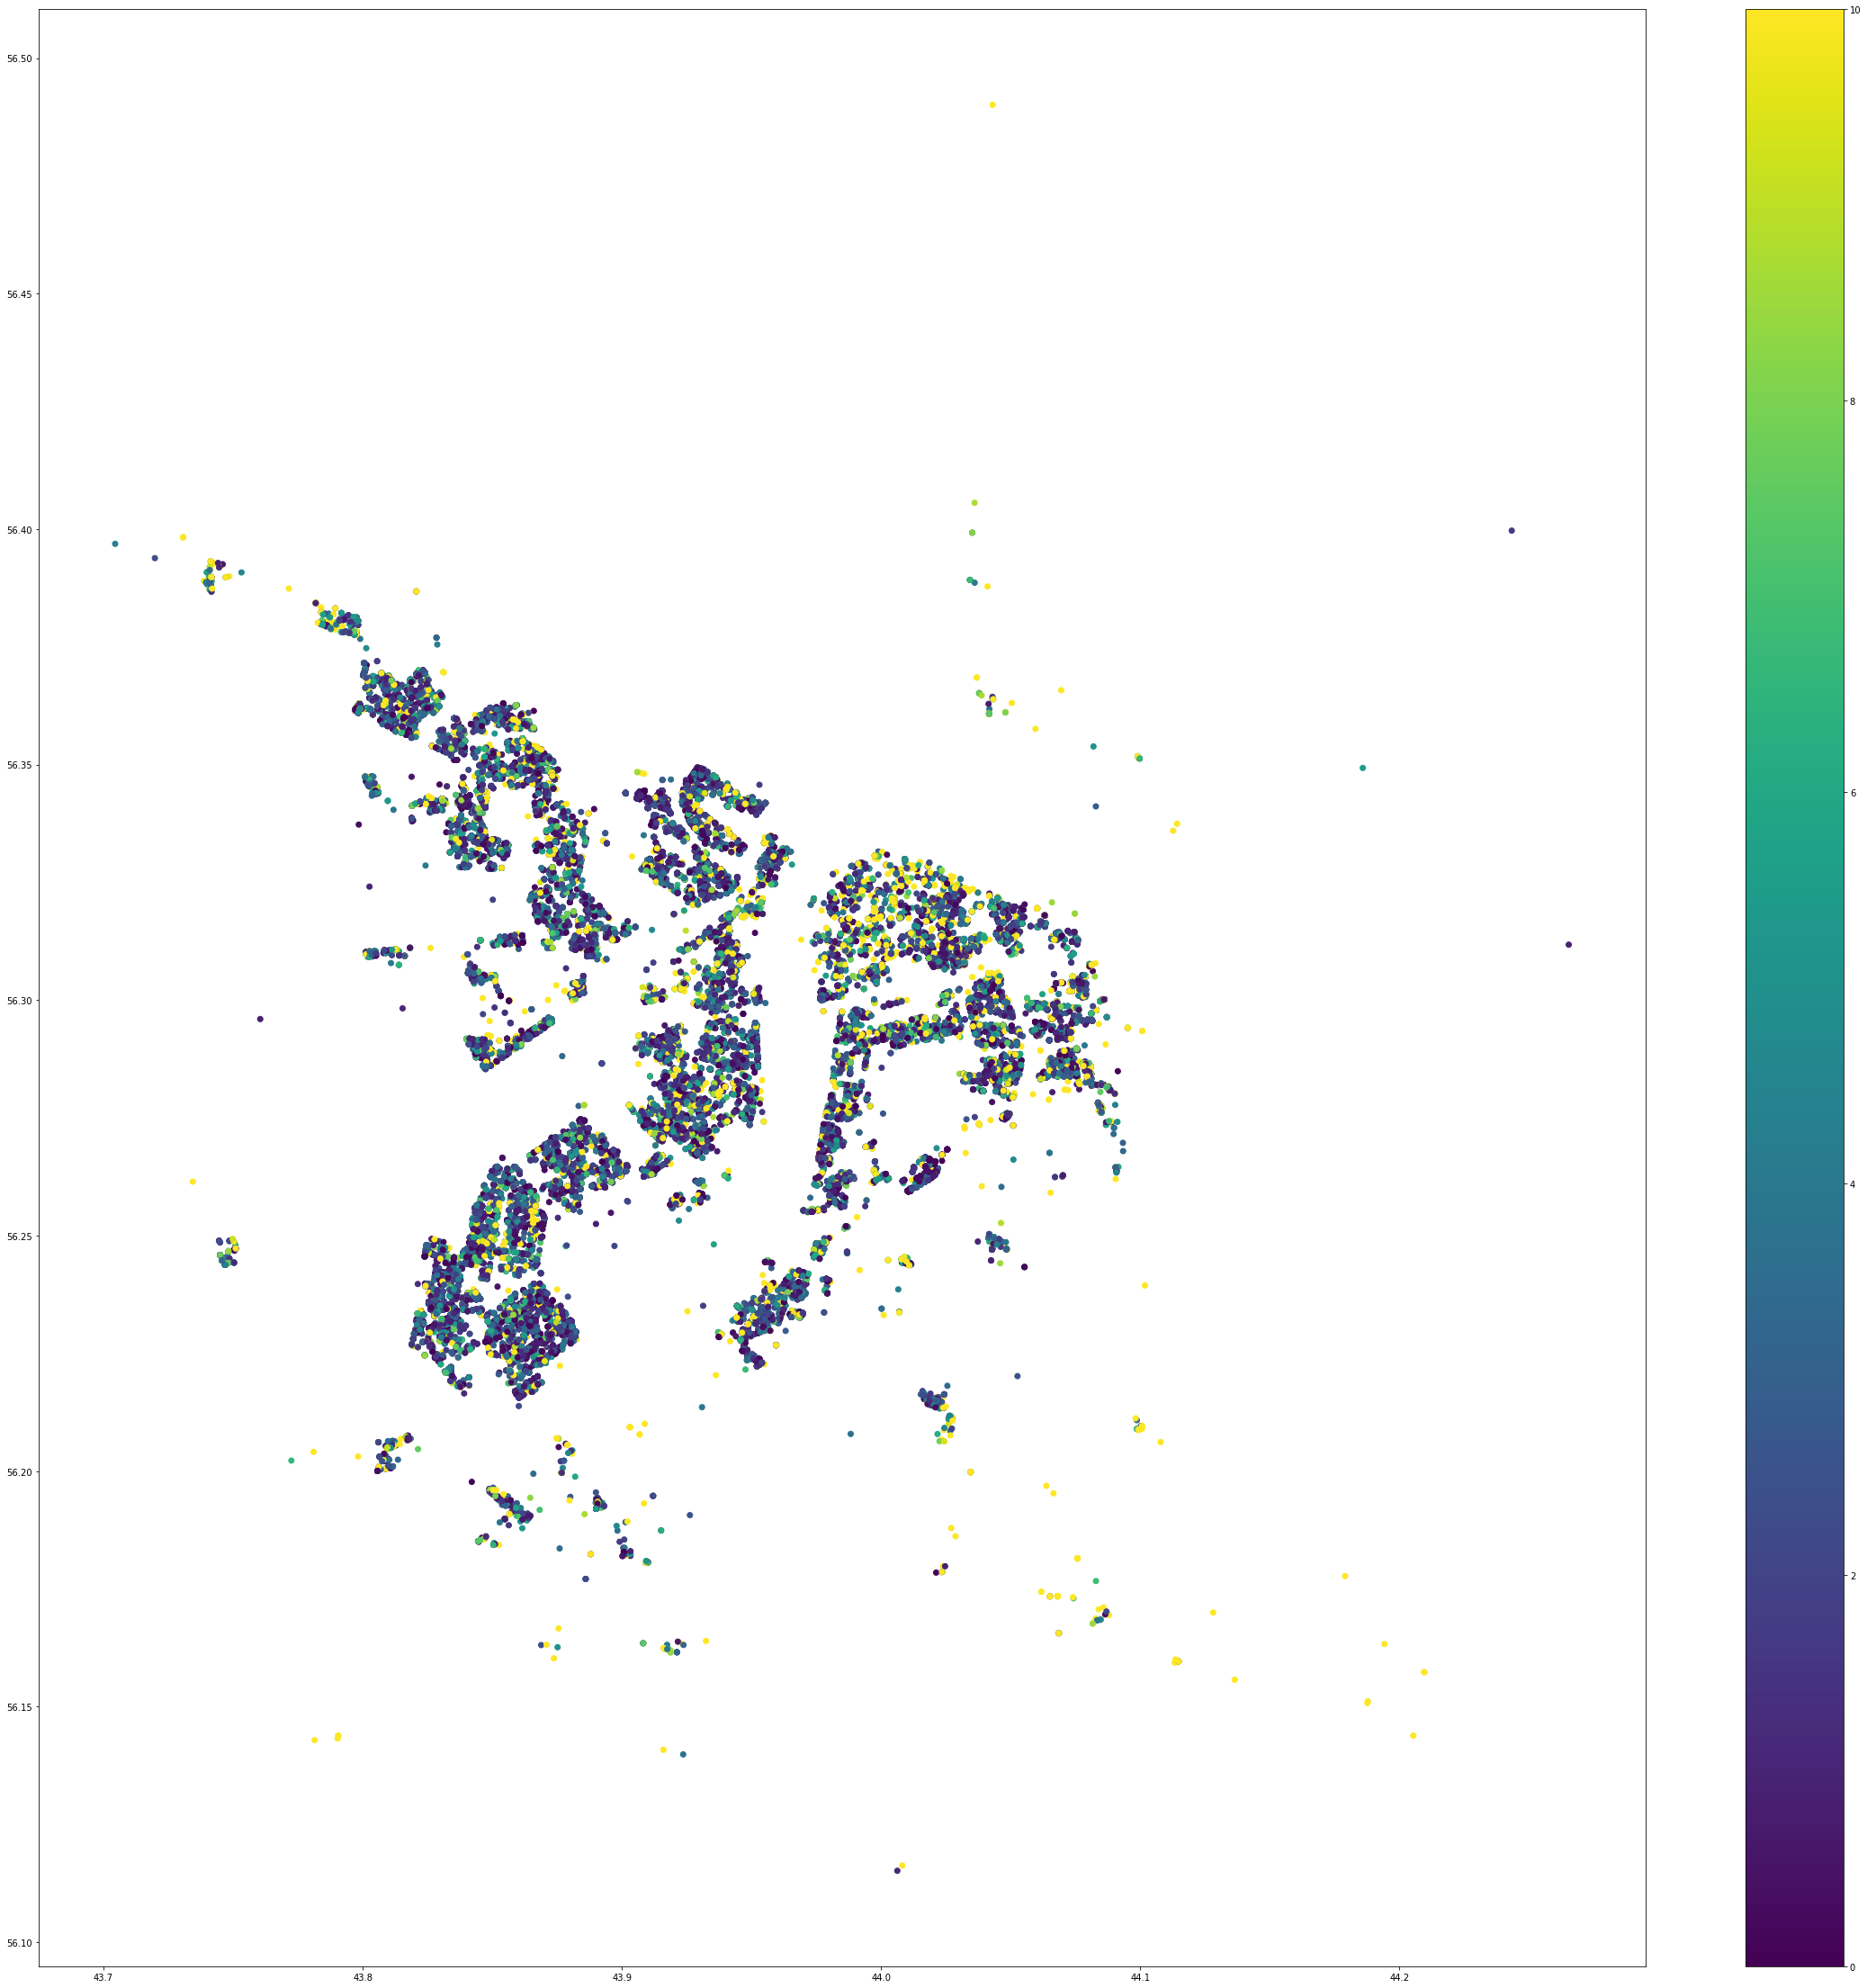

In [3]:
Y_predict = np.array( Y_predict )
Y_values  = np.array( Y_values  )

Y_relErr = np.abs( Y_predict - Y_values )*100/Y_values
for threshold in [ 2.5, 5.0, 10.0 ]:
    bad_s  = np.sum( ( Y_relErr  > threshold ).astype( np.int ) )
    good_s = np.sum( ( Y_relErr <= threshold ).astype( np.int ) )
    print("threshold = {:5}, good = {:10}, bad = {:10}, err = {:4}".format( threshold, good_s, bad_s, bad_s/(good_s+bad_s)) )
x =  X_values[:,0]; y = X_values[:,1]; c = np.minimum(  Y_relErr, 10 );

plt.figure(figsize=(40,40))

plt.scatter (x, y, c=c  )
plt.colorbar()
plt.show    ()

In [4]:
from commonModel import MAX_LONGITUDE, MIN_LONGITUDE, MAX_LATITUDE, MIN_LATITUDE

import warnings
warnings.filterwarnings('ignore')

topK = 10

eps_x = ( MAX_LONGITUDE - MIN_LONGITUDE )*0.001
eps_y = ( MAX_LATITUDE  - MIN_LATITUDE  )*0.001
eps   = min( eps_x, eps_y )

topRelErrIndices = Y_relErr.argsort()[-topK:][::-1]
for i in topRelErrIndices :
    base_row = allDataFrame.iloc[ i ]
    base_x = base_row.longitude 
    base_y = base_row.latitude  
    print("BASE record")
    print( base_row )
    
    for index, cand_row in allDataFrame.iterrows():
        cand_x = cand_row.longitude
        cand_y = cand_row.latitude
        
        distance = np.sqrt( (cand_x-base_x)*(cand_x-base_x) + (cand_y-base_y)*(cand_y-base_y) )
        if distance < eps :
            print("CLOSEST record")
            print( cand_row )
    print("")
    

BASE record
type                Вторичка
price               1.85e+06
longitude            43.8542
latitude             56.3586
total_square              59
living_square             43
kitchen_square            12
number_of_rooms            2
floor_number               3
number_of_floors          10
building_type               
Name: 39068, dtype: object
CLOSEST record
type                 Вторичка
price                 3.3e+06
longitude             43.8542
latitude              56.3586
total_square             40.6
living_square            18.7
kitchen_square            9.8
number_of_rooms             1
floor_number                2
number_of_floors           10
building_type       Кирпичный
Name: 12104, dtype: object
CLOSEST record
type                 Вторичка
price                 3.3e+06
longitude             43.8542
latitude              56.3586
total_square               43
living_square              19
kitchen_square             10
number_of_rooms             1
floor_number   

CLOSEST record
type                 Вторичка
price                   2e+06
longitude             44.0255
latitude              56.3211
total_square               56
living_square              35
kitchen_square             10
number_of_rooms             1
floor_number                4
number_of_floors           10
building_type       Панельный
Name: 84552, dtype: object

BASE record
type                Вторичка
price                3.5e+06
longitude             44.006
latitude             56.3269
total_square             104
living_square             66
kitchen_square             9
number_of_rooms            5
floor_number               2
number_of_floors           2
building_type               
Name: 90109, dtype: object
CLOSEST record
type                Вторичка
price                1.7e+06
longitude             44.006
latitude             56.3269
total_square            31.2
living_square           14.5
kitchen_square           8.2
number_of_rooms            1
floor_number          

CLOSEST record
type                Вторичка
price               2.45e+06
longitude             44.006
latitude             56.3269
total_square              48
living_square             28
kitchen_square           6.3
number_of_rooms            2
floor_number               3
number_of_floors           9
building_type               
Name: 3186, dtype: object
CLOSEST record
type                 Вторичка
price                4.12e+06
longitude              44.006
latitude              56.3269
total_square               61
living_square            39.4
kitchen_square            7.5
number_of_rooms             3
floor_number                8
number_of_floors            9
building_type       Кирпичный
Name: 3190, dtype: object
CLOSEST record
type                Вторичка
price                2.2e+06
longitude             44.006
latitude             56.3269
total_square              34
living_square             18
kitchen_square           9.2
number_of_rooms            1
floor_number          

CLOSEST record
type                 Вторичка
price                2.45e+06
longitude              44.006
latitude              56.3269
total_square               43
living_square              26
kitchen_square            7.7
number_of_rooms             2
floor_number                1
number_of_floors            2
building_type       Кирпичный
Name: 11106, dtype: object
CLOSEST record
type                 Вторичка
price                 8.9e+06
longitude              44.006
latitude              56.3269
total_square              168
living_square              98
kitchen_square             21
number_of_rooms             5
floor_number                6
number_of_floors            7
building_type       Кирпичный
Name: 11107, dtype: object
CLOSEST record
type                Вторичка
price                4.1e+06
longitude             44.006
latitude             56.3269
total_square            75.5
living_square           37.7
kitchen_square            13
number_of_rooms            2
floor_num

CLOSEST record
type                 Вторичка
price                3.99e+06
longitude              44.006
latitude              56.3269
total_square             62.5
living_square              50
kitchen_square            7.5
number_of_rooms             3
floor_number                2
number_of_floors            5
building_type       Кирпичный
Name: 14856, dtype: object
CLOSEST record
type                Вторичка
price                  3e+06
longitude             44.006
latitude             56.3269
total_square            35.5
living_square             18
kitchen_square             9
number_of_rooms            1
floor_number               8
number_of_floors           9
building_type               
Name: 14869, dtype: object
CLOSEST record
type                Вторичка
price                3.3e+06
longitude             44.006
latitude             56.3269
total_square              57
living_square             37
kitchen_square             9
number_of_rooms            3
floor_number        

CLOSEST record
type                Вторичка
price               1.95e+06
longitude             44.006
latitude             56.3269
total_square              33
living_square             27
kitchen_square             6
number_of_rooms            1
floor_number               5
number_of_floors           5
building_type               
Name: 18691, dtype: object
CLOSEST record
type                 Вторичка
price                1.32e+06
longitude              44.006
latitude              56.3269
total_square             33.6
living_square            20.5
kitchen_square              6
number_of_rooms             1
floor_number                1
number_of_floors            3
building_type       Кирпичный
Name: 18909, dtype: object
CLOSEST record
type                Вторичка
price                  4e+06
longitude             44.006
latitude             56.3269
total_square              62
living_square             31
kitchen_square            11
number_of_rooms            2
floor_number        

CLOSEST record
type                Вторичка
price               4.55e+06
longitude             44.006
latitude             56.3269
total_square              69
living_square             35
kitchen_square            11
number_of_rooms            2
floor_number              17
number_of_floors          17
building_type               
Name: 25313, dtype: object
CLOSEST record
type                Вторичка
price                3.5e+06
longitude             44.006
latitude             56.3269
total_square              70
living_square           44.7
kitchen_square           8.5
number_of_rooms            3
floor_number               9
number_of_floors           9
building_type               
Name: 25354, dtype: object
CLOSEST record
type                Вторичка
price                2.1e+06
longitude             44.006
latitude             56.3269
total_square              45
living_square             27
kitchen_square             7
number_of_rooms            2
floor_number               8
nu

CLOSEST record
type                 Вторичка
price                 3.2e+06
longitude              44.006
latitude              56.3269
total_square               43
living_square              28
kitchen_square             10
number_of_rooms             1
floor_number                9
number_of_floors           12
building_type       Кирпичный
Name: 31226, dtype: object
CLOSEST record
type                 Вторичка
price                 4.1e+06
longitude              44.006
latitude              56.3269
total_square               76
living_square            47.3
kitchen_square            7.6
number_of_rooms             3
floor_number                3
number_of_floors            6
building_type       Кирпичный
Name: 31228, dtype: object
CLOSEST record
type                  Вторичка
price                 3.05e+06
longitude               44.006
latitude               56.3269
total_square              41.2
living_square             18.9
kitchen_square            10.6
number_of_rooms         

CLOSEST record
type                Вторичка
price                 850000
longitude             44.006
latitude             56.3269
total_square            26.2
living_square           14.1
kitchen_square           6.2
number_of_rooms            1
floor_number               1
number_of_floors           2
building_type               
Name: 37857, dtype: object
CLOSEST record
type                 Вторичка
price                2.98e+06
longitude              44.006
latitude              56.3269
total_square             38.7
living_square            17.6
kitchen_square            8.6
number_of_rooms             1
floor_number                9
number_of_floors           10
building_type       Кирпичный
Name: 37897, dtype: object
CLOSEST record
type                Вторичка
price                4.2e+06
longitude             44.006
latitude             56.3269
total_square            75.5
living_square           37.7
kitchen_square            13
number_of_rooms            2
floor_number        

CLOSEST record
type                 Вторичка
price                 1.7e+06
longitude              44.006
latitude              56.3269
total_square             52.2
living_square              28
kitchen_square            9.3
number_of_rooms             2
floor_number                3
number_of_floors            5
building_type       Панельный
Name: 44028, dtype: object
CLOSEST record
type                Вторичка
price               2.85e+06
longitude             44.006
latitude             56.3269
total_square              45
living_square             30
kitchen_square             6
number_of_rooms            2
floor_number               1
number_of_floors          45
building_type               
Name: 44109, dtype: object
CLOSEST record
type                 Вторичка
price                3.84e+06
longitude              44.006
latitude              56.3269
total_square               60
living_square              23
kitchen_square             17
number_of_rooms             1
floor_number

CLOSEST record
type                 Вторичка
price                 1.2e+06
longitude              44.006
latitude              56.3269
total_square               36
living_square              24
kitchen_square             12
number_of_rooms             2
floor_number                3
number_of_floors            5
building_type       Кирпичный
Name: 53666, dtype: object
CLOSEST record
type                 Вторичка
price                2.15e+06
longitude              44.006
latitude              56.3269
total_square               37
living_square              18
kitchen_square              9
number_of_rooms             1
floor_number               12
number_of_floors           14
building_type       Кирпичный
Name: 53667, dtype: object
CLOSEST record
type                 Вторичка
price                 2.4e+06
longitude              44.006
latitude              56.3269
total_square             46.3
living_square            30.7
kitchen_square            5.1
number_of_rooms             2
f

CLOSEST record
type                 Вторичка
price                 2.8e+06
longitude              44.006
latitude              56.3269
total_square               42
living_square              28
kitchen_square              6
number_of_rooms             2
floor_number                5
number_of_floors            5
building_type       Кирпичный
Name: 60226, dtype: object
CLOSEST record
type                 Вторичка
price                 3.2e+06
longitude              44.006
latitude              56.3269
total_square               60
living_square              40
kitchen_square              9
number_of_rooms             3
floor_number                1
number_of_floors            9
building_type       Панельный
Name: 60304, dtype: object
CLOSEST record
type                 Вторичка
price                 3.7e+06
longitude              44.006
latitude              56.3269
total_square               54
living_square            34.4
kitchen_square            4.5
number_of_rooms             3
f

type                Вторичка
price                3.6e+06
longitude             44.006
latitude             56.3269
total_square              65
living_square             40
kitchen_square             8
number_of_rooms            3
floor_number               3
number_of_floors           9
building_type               
Name: 67522, dtype: object
CLOSEST record
type                Вторичка
price                1.6e+06
longitude             44.006
latitude             56.3269
total_square              51
living_square             32
kitchen_square             6
number_of_rooms            2
floor_number               5
number_of_floors           5
building_type               
Name: 67998, dtype: object
CLOSEST record
type                 Вторичка
price                1.65e+06
longitude              44.006
latitude              56.3269
total_square             39.2
living_square            30.1
kitchen_square            5.4
number_of_rooms             2
floor_number                2
number_o

CLOSEST record
type                 Вторичка
price                1.65e+06
longitude              44.006
latitude              56.3269
total_square             21.4
living_square            11.8
kitchen_square            5.1
number_of_rooms             1
floor_number                6
number_of_floors            6
building_type       Кирпичный
Name: 75623, dtype: object
CLOSEST record
type                 Вторичка
price                 4.2e+06
longitude              44.006
latitude              56.3269
total_square             67.3
living_square            39.2
kitchen_square              7
number_of_rooms             3
floor_number                9
number_of_floors            9
building_type       Кирпичный
Name: 75624, dtype: object
CLOSEST record
type                 Вторичка
price                 2.3e+06
longitude              44.006
latitude              56.3269
total_square               45
living_square              31
kitchen_square              6
number_of_rooms             2
f

Name: 83273, dtype: object
CLOSEST record
type                 Вторичка
price                3.62e+06
longitude              44.006
latitude              56.3269
total_square             43.6
living_square              32
kitchen_square              6
number_of_rooms             2
floor_number                2
number_of_floors            5
building_type       Кирпичный
Name: 83706, dtype: object
CLOSEST record
type                 Вторичка
price                1.92e+06
longitude              44.006
latitude              56.3269
total_square             32.9
living_square            18.4
kitchen_square            6.2
number_of_rooms             1
floor_number                1
number_of_floors            9
building_type       Панельный
Name: 83707, dtype: object
CLOSEST record
type                 Вторичка
price                 2.4e+06
longitude              44.006
latitude              56.3269
total_square             31.1
living_square            15.8
kitchen_square            6.1
numb

Name: 89373, dtype: object
CLOSEST record
type                 Вторичка
price                2.05e+06
longitude              44.006
latitude              56.3269
total_square             38.5
living_square              24
kitchen_square            5.2
number_of_rooms             2
floor_number                1
number_of_floors            5
building_type       Панельный
Name: 89379, dtype: object
CLOSEST record
type                 Вторичка
price                 6.8e+06
longitude              44.006
latitude              56.3269
total_square             94.3
living_square              54
kitchen_square             12
number_of_rooms             3
floor_number                9
number_of_floors            9
building_type       Кирпичный
Name: 89381, dtype: object
CLOSEST record
type                 Вторичка
price                4.93e+06
longitude              44.006
latitude              56.3269
total_square               70
living_square              62
kitchen_square              8
numb

Name: 92972, dtype: object
CLOSEST record
type                 Вторичка
price                 2.6e+06
longitude              44.006
latitude              56.3269
total_square             35.4
living_square            17.7
kitchen_square            7.2
number_of_rooms             1
floor_number                3
number_of_floors            9
building_type       Панельный
Name: 92974, dtype: object
CLOSEST record
type                 Вторичка
price                2.86e+06
longitude              44.006
latitude              56.3269
total_square               50
living_square              31
kitchen_square            6.5
number_of_rooms             2
floor_number                3
number_of_floors            5
building_type       Кирпичный
Name: 92976, dtype: object
CLOSEST record
type                 Вторичка
price                 2.7e+06
longitude              44.006
latitude              56.3269
total_square             37.4
living_square            17.9
kitchen_square            8.3
numb

CLOSEST record
type                Вторичка
price                1.9e+06
longitude             44.006
latitude             56.3269
total_square            30.5
living_square           16.5
kitchen_square           6.5
number_of_rooms            1
floor_number               4
number_of_floors           5
building_type               
Name: 97973, dtype: object
CLOSEST record
type                 Вторичка
price                 9.5e+06
longitude              44.006
latitude              56.3269
total_square              130
living_square              60
kitchen_square             25
number_of_rooms             3
floor_number                1
number_of_floors            5
building_type       Кирпичный
Name: 98045, dtype: object
CLOSEST record
type                 Вторичка
price                1.17e+07
longitude              44.006
latitude              56.3269
total_square              150
living_square              80
kitchen_square             16
number_of_rooms             4
floor_number

CLOSEST record
type                 Вторичка
price                   2e+06
longitude              44.006
latitude              56.3269
total_square             31.4
living_square              18
kitchen_square              6
number_of_rooms             1
floor_number                3
number_of_floors            4
building_type       Кирпичный
Name: 105552, dtype: object
CLOSEST record
type                 Вторичка
price                3.45e+06
longitude              44.006
latitude              56.3269
total_square             58.6
living_square            24.7
kitchen_square           18.8
number_of_rooms             3
floor_number                3
number_of_floors           12
building_type       Кирпичный
Name: 105558, dtype: object
CLOSEST record
type                 Вторичка
price                4.35e+06
longitude              44.006
latitude              56.3269
total_square             63.7
living_square              39
kitchen_square              9
number_of_rooms             3

CLOSEST record
type                Новостройка
price                   3.6e+06
longitude               44.0323
latitude                56.2728
total_square                 68
living_square                30
kitchen_square               18
number_of_rooms               3
floor_number                  2
number_of_floors             18
building_type        Монолитный
Name: 96901, dtype: object

BASE record
type                 Вторичка
price                 2.9e+06
longitude             44.0075
latitude              56.3269
total_square               86
living_square              60
kitchen_square              8
number_of_rooms             4
floor_number                3
number_of_floors            4
building_type       Кирпичный
Name: 20423, dtype: object
CLOSEST record
type                 Вторичка
price                3.15e+06
longitude             44.0075
latitude              56.3269
total_square             60.7
living_square            41.5
kitchen_square            5.7
number_of_r

CLOSEST record
type                 Вторичка
price                1.85e+06
longitude             44.0075
latitude              56.3269
total_square               29
living_square            17.3
kitchen_square            5.5
number_of_rooms             1
floor_number                6
number_of_floors            9
building_type       Кирпичный
Name: 98281, dtype: object
CLOSEST record
type                 Вторичка
price                 2.5e+06
longitude             44.0075
latitude              56.3269
total_square               56
living_square              30
kitchen_square              9
number_of_rooms             1
floor_number                5
number_of_floors           10
building_type       Панельный
Name: 103272, dtype: object

BASE record
type                 Вторичка
price                3.98e+06
longitude              44.084
latitude              56.1707
total_square              120
living_square              85
kitchen_square           15.5
number_of_rooms             2
fl

CLOSEST record
type                Вторичка
price               2.45e+06
longitude             44.006
latitude             56.3269
total_square              48
living_square             28
kitchen_square           6.3
number_of_rooms            2
floor_number               3
number_of_floors           9
building_type               
Name: 3186, dtype: object
CLOSEST record
type                 Вторичка
price                4.12e+06
longitude              44.006
latitude              56.3269
total_square               61
living_square            39.4
kitchen_square            7.5
number_of_rooms             3
floor_number                8
number_of_floors            9
building_type       Кирпичный
Name: 3190, dtype: object
CLOSEST record
type                Вторичка
price                2.2e+06
longitude             44.006
latitude             56.3269
total_square              34
living_square             18
kitchen_square           9.2
number_of_rooms            1
floor_number          

Name: 10257, dtype: object
CLOSEST record
type                 Вторичка
price                 2.9e+06
longitude              44.006
latitude              56.3269
total_square               55
living_square            36.5
kitchen_square              6
number_of_rooms             3
floor_number                4
number_of_floors            5
building_type       Кирпичный
Name: 10260, dtype: object
CLOSEST record
type                 Вторичка
price                   3e+06
longitude              44.006
latitude              56.3269
total_square               42
living_square            21.4
kitchen_square           10.7
number_of_rooms             1
floor_number                6
number_of_floors           10
building_type       Кирпичный
Name: 10276, dtype: object
CLOSEST record
type                Вторичка
price                2.3e+06
longitude             44.006
latitude             56.3269
total_square           43.09
living_square          15.96
kitchen_square         13.59
number_of_r

CLOSEST record
type                 Вторичка
price                2.06e+06
longitude              44.006
latitude              56.3269
total_square               47
living_square              30
kitchen_square              7
number_of_rooms             2
floor_number                5
number_of_floors            5
building_type       Панельный
Name: 13230, dtype: object
CLOSEST record
type                Вторичка
price               2.15e+06
longitude             44.006
latitude             56.3269
total_square              46
living_square             30
kitchen_square             6
number_of_rooms            2
floor_number               4
number_of_floors           5
building_type               
Name: 13324, dtype: object
CLOSEST record
type                Вторичка
price                1.7e+06
longitude             44.006
latitude             56.3269
total_square            30.6
living_square           14.5
kitchen_square           8.5
number_of_rooms            1
floor_number        

CLOSEST record
type                Вторичка
price               2.59e+06
longitude             44.006
latitude             56.3269
total_square              43
living_square             29
kitchen_square             6
number_of_rooms            2
floor_number               2
number_of_floors           5
building_type               
Name: 17850, dtype: object
CLOSEST record
type                Вторичка
price               2.18e+06
longitude             44.006
latitude             56.3269
total_square            53.4
living_square             34
kitchen_square           6.6
number_of_rooms            3
floor_number               2
number_of_floors           2
building_type               
Name: 17851, dtype: object
CLOSEST record
type                Вторичка
price               1.65e+06
longitude             44.006
latitude             56.3269
total_square              33
living_square             16
kitchen_square             5
number_of_rooms            1
floor_number               3
nu

CLOSEST record
type                Вторичка
price               3.55e+06
longitude             44.006
latitude             56.3269
total_square              55
living_square             31
kitchen_square           8.5
number_of_rooms            2
floor_number               7
number_of_floors           9
building_type               
Name: 23276, dtype: object
CLOSEST record
type                Вторичка
price                2.2e+06
longitude             44.006
latitude             56.3269
total_square              47
living_square             40
kitchen_square             7
number_of_rooms            2
floor_number               1
number_of_floors           5
building_type               
Name: 23370, dtype: object
CLOSEST record
type                Вторичка
price                4.7e+06
longitude             44.006
latitude             56.3269
total_square            67.9
living_square           41.6
kitchen_square           9.5
number_of_rooms            3
floor_number               8
nu

CLOSEST record
type                 Вторичка
price                2.95e+06
longitude              44.006
latitude              56.3269
total_square               66
living_square              39
kitchen_square              9
number_of_rooms             2
floor_number                4
number_of_floors            9
building_type       Кирпичный
Name: 29371, dtype: object
CLOSEST record
type                Новостройка
price                   4.7e+06
longitude                44.006
latitude                56.3269
total_square                 97
living_square                80
kitchen_square               12
number_of_rooms               3
floor_number                  8
number_of_floors             12
building_type        Монолитный
Name: 29452, dtype: object
CLOSEST record
type                  Вторичка
price                 1.41e+06
longitude               44.006
latitude               56.3269
total_square                31
living_square               15
kitchen_square             8.6
nu

CLOSEST record
type                   Вторичка
price               1.99099e+06
longitude                44.006
latitude                56.3269
total_square               31.7
living_square              18.9
kitchen_square              5.5
number_of_rooms               1
floor_number                  1
number_of_floors              5
building_type         Кирпичный
Name: 35078, dtype: object
CLOSEST record
type                 Вторичка
price                 2.5e+06
longitude              44.006
latitude              56.3269
total_square             42.4
living_square            27.9
kitchen_square            5.4
number_of_rooms             2
floor_number                2
number_of_floors            5
building_type       Панельный
Name: 35079, dtype: object
CLOSEST record
type                 Вторичка
price                 2.4e+06
longitude              44.006
latitude              56.3269
total_square               35
living_square              19
kitchen_square              9
number_of

CLOSEST record
type                Вторичка
price                2.2e+06
longitude             44.006
latitude             56.3269
total_square              31
living_square             19
kitchen_square             6
number_of_rooms            1
floor_number               3
number_of_floors           5
building_type               
Name: 43687, dtype: object
CLOSEST record
type                 Вторичка
price                 1.7e+06
longitude              44.006
latitude              56.3269
total_square             52.2
living_square              28
kitchen_square            9.3
number_of_rooms             2
floor_number                3
number_of_floors            5
building_type       Панельный
Name: 44028, dtype: object
CLOSEST record
type                Вторичка
price               2.85e+06
longitude             44.006
latitude             56.3269
total_square              45
living_square             30
kitchen_square             6
number_of_rooms            2
floor_number        

CLOSEST record
type                Вторичка
price               1.85e+06
longitude             44.006
latitude             56.3269
total_square              38
living_square             17
kitchen_square            10
number_of_rooms            1
floor_number               2
number_of_floors           5
building_type               
Name: 52428, dtype: object
CLOSEST record
type                Вторичка
price               3.15e+06
longitude             44.006
latitude             56.3269
total_square            61.5
living_square             48
kitchen_square           6.5
number_of_rooms            3
floor_number               4
number_of_floors           5
building_type               
Name: 53144, dtype: object
CLOSEST record
type                  Вторичка
price                 2.95e+06
longitude               44.006
latitude               56.3269
total_square                41
living_square             16.5
kitchen_square              10
number_of_rooms              1
floor_number   

CLOSEST record
type                 Вторичка
price                 1.9e+06
longitude              44.006
latitude              56.3269
total_square             29.9
living_square            16.7
kitchen_square            6.3
number_of_rooms             1
floor_number                3
number_of_floors            5
building_type       Кирпичный
Name: 58980, dtype: object
CLOSEST record
type                 Вторичка
price                   3e+06
longitude              44.006
latitude              56.3269
total_square             48.5
living_square            20.3
kitchen_square           11.5
number_of_rooms             1
floor_number                2
number_of_floors           10
building_type       Кирпичный
Name: 59452, dtype: object
CLOSEST record
type                 Вторичка
price                 1.7e+06
longitude              44.006
latitude              56.3269
total_square             30.2
living_square            17.5
kitchen_square            5.3
number_of_rooms             1
f

CLOSEST record
type                Вторичка
price                3.7e+06
longitude             44.006
latitude             56.3269
total_square              61
living_square             45
kitchen_square           7.5
number_of_rooms            3
floor_number               1
number_of_floors           9
building_type               
Name: 70871, dtype: object
CLOSEST record
type                 Вторичка
price                 1.7e+06
longitude              44.006
latitude              56.3269
total_square               22
living_square              12
kitchen_square            5.5
number_of_rooms             1
floor_number                6
number_of_floors            9
building_type       Кирпичный
Name: 70921, dtype: object
CLOSEST record
type                 Вторичка
price                 2.1e+06
longitude              44.006
latitude              56.3269
total_square             44.3
living_square              28
kitchen_square              6
number_of_rooms             2
floor_number

CLOSEST record
type                 Вторичка
price                1.55e+06
longitude              44.006
latitude              56.3269
total_square               31
living_square              18
kitchen_square            5.5
number_of_rooms             1
floor_number                5
number_of_floors            5
building_type       Кирпичный
Name: 81596, dtype: object
CLOSEST record
type                 Вторичка
price                3.65e+06
longitude              44.006
latitude              56.3269
total_square               52
living_square            32.8
kitchen_square            6.1
number_of_rooms             2
floor_number                5
number_of_floors            9
building_type       Кирпичный
Name: 81674, dtype: object
CLOSEST record
type                 Вторичка
price                1.39e+06
longitude              44.006
latitude              56.3269
total_square               29
living_square              18
kitchen_square              5
number_of_rooms             1
f

CLOSEST record
type                Вторичка
price                3.6e+06
longitude             44.006
latitude             56.3269
total_square            45.9
living_square           16.5
kitchen_square            13
number_of_rooms            1
floor_number               4
number_of_floors          23
building_type               
Name: 86227, dtype: object
CLOSEST record
type                 Вторичка
price                1.65e+06
longitude              44.006
latitude              56.3269
total_square             30.8
living_square            18.5
kitchen_square            5.5
number_of_rooms             1
floor_number                4
number_of_floors            5
building_type       Кирпичный
Name: 86319, dtype: object
CLOSEST record
type                 Вторичка
price                 2.5e+06
longitude              44.006
latitude              56.3269
total_square             32.5
living_square              17
kitchen_square            7.5
number_of_rooms             1
floor_number

CLOSEST record
type                 Вторичка
price                2.75e+06
longitude              44.006
latitude              56.3269
total_square               55
living_square            27.4
kitchen_square            9.1
number_of_rooms             2
floor_number                2
number_of_floors            5
building_type       Кирпичный
Name: 92947, dtype: object
CLOSEST record
type                 Вторичка
price                 5.2e+06
longitude              44.006
latitude              56.3269
total_square               80
living_square              50
kitchen_square              9
number_of_rooms             4
floor_number               10
number_of_floors           10
building_type       Кирпичный
Name: 92949, dtype: object
CLOSEST record
type                 Вторичка
price                1.95e+06
longitude              44.006
latitude              56.3269
total_square             37.3
living_square            28.2
kitchen_square            4.3
number_of_rooms             2
f

CLOSEST record
type                 Вторичка
price                 6.8e+06
longitude              44.006
latitude              56.3269
total_square              121
living_square            72.6
kitchen_square           33.8
number_of_rooms             3
floor_number                9
number_of_floors           14
building_type       Кирпичный
Name: 97019, dtype: object
CLOSEST record
type                Вторичка
price                4.5e+06
longitude             44.006
latitude             56.3269
total_square              78
living_square           43.6
kitchen_square            12
number_of_rooms            3
floor_number               8
number_of_floors          17
building_type               
Name: 97246, dtype: object
CLOSEST record
type                Новостройка
price                  3.55e+06
longitude                44.006
latitude                56.3269
total_square               66.1
living_square              36.6
kitchen_square             10.8
number_of_rooms             

CLOSEST record
type                 Вторичка
price                2.58e+06
longitude              44.006
latitude              56.3269
total_square             46.1
living_square              28
kitchen_square              6
number_of_rooms             2
floor_number                5
number_of_floors            9
building_type       Кирпичный
Name: 103968, dtype: object
CLOSEST record
type                  Вторичка
price                 3.05e+06
longitude               44.006
latitude               56.3269
total_square              42.8
living_square             21.4
kitchen_square              10
number_of_rooms              1
floor_number                16
number_of_floors            17
building_type       Монолитный
Name: 103973, dtype: object
CLOSEST record
type                Вторичка
price                2.3e+06
longitude             44.006
latitude             56.3269
total_square              48
living_square             26
kitchen_square             9
number_of_rooms          

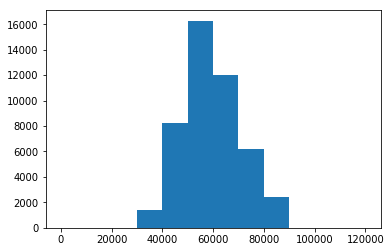

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer

import matplotlib.pyplot as plt

bins = [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000]

pricePerSquare       = allDataFrame['price']/allDataFrame['total_square']
pricePerSquareValues = pricePerSquare.values

plt.hist(  pricePerSquareValues, bins=bins )
plt.show()
